Training


In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import load_data
import submission
import unet

import torch as t
import torchvision.transforms as tsf
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tqdm import tqdm
from loss import soft_dice_loss, score
from utils import label_mask, make_predictions, convert_prediction
from sklearn.model_selection import train_test_split
%matplotlib inline

if t.cuda.is_available():
    print('Using cuda')
    use_cuda = True
else:
    print('Using CPU')
    use_cuda = False

Populating the interactive namespace from numpy and matplotlib
Using cuda


Set model parameters

In [2]:
params = {'learning_rate': 1e-3, 'seed': 41}
t.cuda.manual_seed_all(params['seed'])

Load data

In [3]:
DATA_DIR = 'data'
training_path = DATA_DIR + '/stage1_train'
test_path = DATA_DIR + '/stage1_test'
data = load_data.load_images(training_path)
train_data, val_data = train_test_split(data, test_size=0.2, random_state=params['seed'])
test_data = load_data.load_images(test_path)

100%|██████████| 65/65 [00:00<00:00, 199.84it/s]


Create dataset

In [4]:
to_PIL = load_data.ToPILImage()
resize = load_data.Resize((256, 256))
crop = load_data.RandomCrop(128)
to_tensor = load_data.ToTensor()
normalize = load_data.Normalize()
transform = tsf.Compose([to_PIL, resize, to_tensor, normalize])
valid_transform = tsf.Compose([to_PIL, resize, to_tensor, normalize])
test_transform = tsf.Compose([to_PIL, resize, to_tensor, normalize])

train_dataset = load_data.Dataset(train_data, transform)
valid_dataset = load_data.Dataset(val_data, valid_transform)
test_dataset = load_data.Dataset(test_data, test_transform)

traindataloader = t.utils.data.DataLoader(train_dataset, num_workers=2, batch_size=4)
valdataloader = t.utils.data.DataLoader(valid_dataset, num_workers=2, batch_size=4)
testdataloader = t.utils.data.DataLoader(test_dataset, num_workers=2, batch_size=1)

In [5]:
print(type(train_data))

<class 'list'>


uint8
1.0


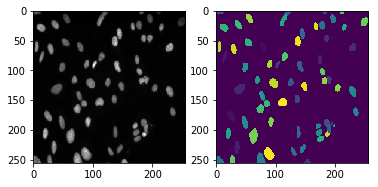

In [6]:

print(train_data[0]['image'].dtype)
sample = train_dataset[2]
img = sample['image']
mask = sample['cum_mask']
print(np.max(img.numpy()))
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5 + 0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

Train network

In [7]:
model = unet.UNet(3, 1)
if use_cuda:
    model.cuda()
training_losses = []
valid_losses = []
training_scores = []
valid_scores = []
loaders_list = [traindataloader, valdataloader]
losses_list = [training_losses, valid_losses]
scores_list = [training_scores, valid_scores]
data_list = [train_data, val_data]
optimizer = t.optim.Adam(model.parameters(),lr = params['learning_rate'])
scheduler = t.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
for epoch in tqdm(range(100)):
    for sample in traindataloader:
        model.train()
        x_train = sample['image']
        y_train = sample['mask']
        if use_cuda:
            x_train = x_train.cuda()
            y_train = y_train.cuda()
        x_train = t.autograd.Variable(x_train)
        y_train = t.autograd.Variable(y_train)
        optimizer.zero_grad()
        o = model(x_train)
        loss = soft_dice_loss(o, y_train)
        loss.backward()
        optimizer.step()
    # validation
    model.eval()
    for loader, losses, scores, data in zip(loaders_list, losses_list, scores_list, data_list):
        loss_vals = []
        score_vals = []
        for batch in loader:
            x = batch['image']
            y = batch['mask']
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
            x = t.autograd.Variable(x)
            y = t.autograd.Variable(y)
            o = model(x)
            loss = soft_dice_loss(o, y)
            loss_vals.append(loss.data.cpu().numpy()[0])

            prediction, _ = convert_prediction(o, batch)
            cum_masks = [data[idx]['cum_mask'][:, :, 0] for idx in batch['idx']]
            score_vals.append(score(prediction, cum_masks))
        losses.append(np.mean(loss_vals))
        scores.append(np.mean(score_vals))
    scheduler.step(valid_losses[-1])
    


100%|██████████| 100/100 [45:16<00:00, 27.17s/it]


Plot loss

Train score: 0.4277642624609902
Valid score: 0.47916921300832127


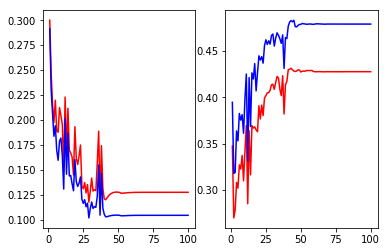

In [8]:
epoches = range(1, len(training_losses) + 1)
plt.subplot(121)
plt.plot(epoches, training_losses, 'r', epoches, valid_losses, 'b')
plt.subplot(122)
plt.plot(epoches, training_scores, 'r', epoches, valid_scores, 'b')
training_loss = training_losses[-1]
valid_loss = valid_losses[-1]
training_score = training_scores[-1]
valid_score = valid_scores[-1]
print('Train score:', training_score)
print('Valid score:', valid_score)

Run on validation dataset

In [9]:
names, masks, tms, indices = make_predictions(model, valdataloader, use_cuda=use_cuda)

(256, 320, 3)
(256, 320)
(256, 320)
(256, 320, 1)
a0325cb7aa59e9c0a75e64ba26855d8032c46161aa4bca0c01bac5e4a836485e
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
Plot sample 2


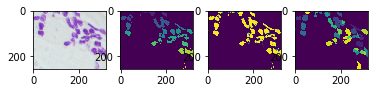

In [10]:
idx = 2
#print(val_data[indices[idx]]['height'], val_data[indices[idx]]['height'])
print(val_data[indices[idx]]['image'].shape)
print(masks[idx].shape)
print(tms[idx].shape)
print(val_data[indices[idx]]['cum_mask'].shape)
print(names[idx])
print(np.unique(masks[idx]))
print('Plot sample %d' % idx)
plt.subplot(141)
plt.imshow(val_data[indices[idx]]['image'])
plt.subplot(142)
plt.imshow(masks[idx])
plt.subplot(143)
plt.imshow(tms[idx])
plt.subplot(144)
plt.imshow(val_data[indices[idx]]['cum_mask'][:, :, 0])

Run on test data

In [11]:
names, masks, tms, indices = make_predictions(model, testdataloader, use_cuda=use_cuda)

(256, 256, 3)
(256, 256)
(256, 256)
7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4ff47b3e1e3a2b403af
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Plot sample 5


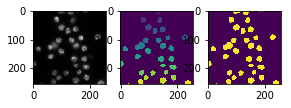

In [12]:
idx = 5
#print(val_data[indices[idx]]['height'], val_data[indices[idx]]['height'])
print(test_data[indices[idx]]['image'].shape)
print(masks[idx].shape)
print(tms[idx].shape)
print(names[idx])
print(np.unique(masks[idx]))
print('Plot sample %d' % idx)
plt.subplot(141)
plt.imshow(test_data[indices[idx]]['image'])
plt.subplot(142)
plt.imshow(masks[idx])
plt.subplot(143)
plt.imshow(tms[idx])

In [13]:
submission.create_submission(names, masks, 'submision_%f.csv' % valid_score)